# Model reduction_tutorial_week_9

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math

## Happiness score

In [37]:
happy_data = pd.read_csv("2018.csv",sep=',')
happy_data.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.632,1.305,1.592,0.874,0.681,0.202,0.393
1,2,Norway,7.594,1.456,1.582,0.861,0.686,0.286,0.340
2,3,Denmark,7.555,1.351,1.590,0.868,0.683,0.284,0.408
3,4,Iceland,7.495,1.343,1.644,0.914,0.677,0.353,0.138
4,5,Switzerland,7.487,1.420,1.549,0.927,0.660,0.256,0.357


In [38]:
# renaming
happy_data = happy_data.rename(columns={'GDP per capita': 'GDP_per_capita', 
                                        'Overall rank': 'Overall_rank',
                                        'Country or region': 'Coutnry_or_region',
                                        'Social support': 'Social_support', 
                                        'Healthy life expectancy': 'Healthy_life_exp', 
                                        'Freedom to make life choices': 'Freedom_of_life_choices', 
                                        'Perceptions of corruption': 'Perceptions_of_corruption'})

In [39]:
happy_data.info()
# --> no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Overall_rank               156 non-null    int64  
 1   Coutnry_or_region          156 non-null    object 
 2   Score                      156 non-null    float64
 3   GDP_per_capita             156 non-null    float64
 4   Social_support             156 non-null    float64
 5   Healthy_life_exp           156 non-null    float64
 6   Freedom_of_life_choices    156 non-null    float64
 7   Generosity                 156 non-null    float64
 8   Perceptions_of_corruption  156 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+ KB


In [40]:
# splitting in dependent and independent variables
happy_data_ind_var = happy_data.iloc[:, 3:]
happy_data_dep_var = happy_data.loc[:, ["Score"]]

In [41]:
# initiating table
model_used, model_aic, model_deviance = [], [], []

### Null model

In [42]:
formula = 'Score ~ 1'
model = smf.glm(formula, happy_data, family = sm.families.Poisson())
result = model.fit()
print(result.summary())
model_used.append('null model')
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print("The result of the AIC is: ")
print(round(result.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  156
Model:                            GLM   Df Residuals:                      155
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -293.67
Date:                Sun, 15 Dec 2024   Deviance:                       36.719
Time:                        17:40:10   Pearson chi2:                     36.1
No. Iterations:                     4   Pseudo R-squ. (CS):          7.772e-16
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6819      0.035     48.708      0.0

### Correlation - Graphics

<Axes: >

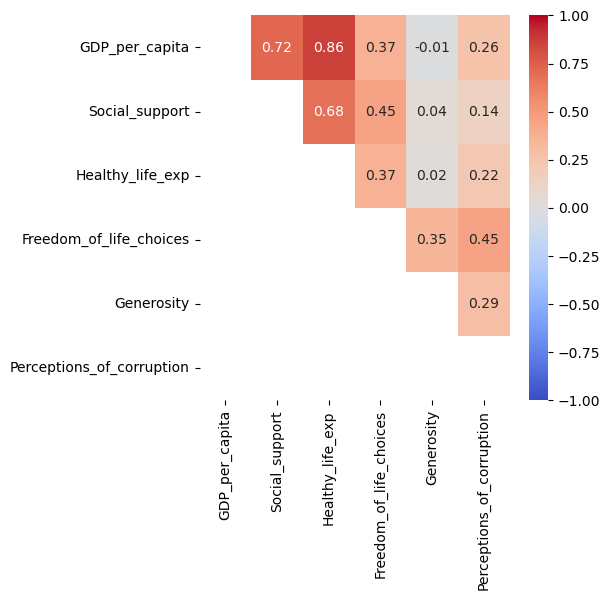

In [43]:
plt.figure(figsize = (5,5))
sns.heatmap(round(happy_data_ind_var.corr(method = 'spearman'),2), mask = np.tril(happy_data_ind_var.corr(method = 'spearman')), vmax=1, vmin=-1, 
            center=0,cmap='coolwarm', annot=True, annot_kws={"size": 10})

array([[<Axes: title={'center': 'GDP_per_capita'}>,
        <Axes: title={'center': 'Social_support'}>],
       [<Axes: title={'center': 'Healthy_life_exp'}>,
        <Axes: title={'center': 'Freedom_of_life_choices'}>],
       [<Axes: title={'center': 'Generosity'}>,
        <Axes: title={'center': 'Perceptions_of_corruption'}>]],
      dtype=object)

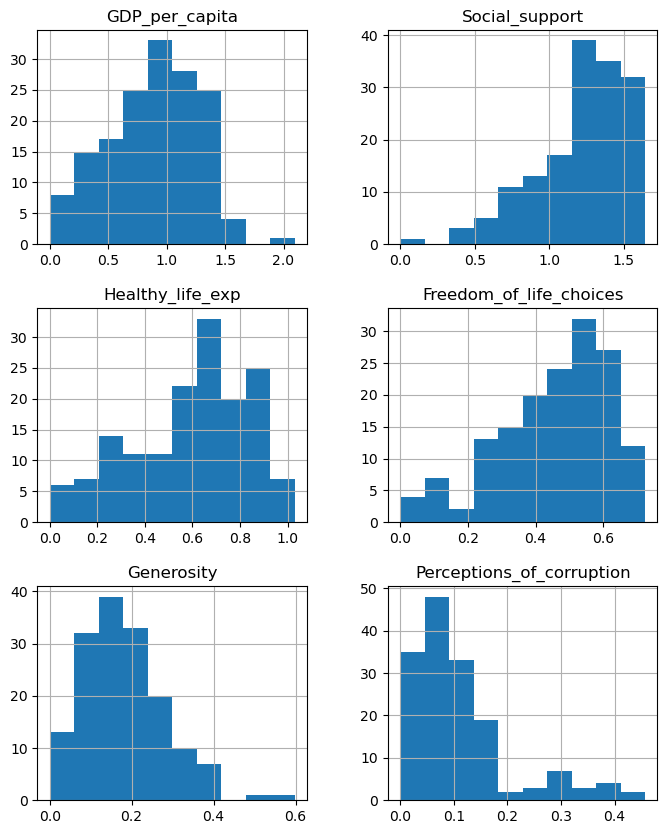

In [44]:
happy_data_ind_var.hist(figsize=(8,10))

Poisson distribution in our models needed; scaling needed

### Min Max Scaling

In [45]:
from sklearn.preprocessing import MinMaxScaler

In [46]:
happy_data_scaled = happy_data
happy_data_scaled = happy_data_scaled.drop(columns=['Overall_rank', 'Coutnry_or_region'])

In [47]:
# scaling the independent variables

# Initialize the scaler
scaler = MinMaxScaler()

scaled_predictors = scaler.fit_transform(happy_data_ind_var)

# Convert scaled predictors back to a DataFrame with the original column names
scaled_predictors = pd.DataFrame(scaled_predictors, columns=happy_data_ind_var.columns, index=happy_data_scaled.index)

# Combine the scaled predictors with the dependent variable
happy_data_scaled = pd.concat([happy_data_dep_var['Score'], scaled_predictors], axis=1)

# Check the scaled DataFrame
happy_data_scaled.head()

,Score,GDP_per_capita,Social_support,Healthy_life_exp,Freedom_of_life_choices,Generosity,Perceptions_of_corruption
0,7.632,0.622615,0.968370,0.848544,0.940608,0.337793,0.859956
1,7.594,0.694656,0.962287,0.835922,0.947514,0.478261,0.743982
2,7.555,0.644561,0.967153,0.842718,0.943370,0.474916,0.892779
3,7.495,0.640744,1.000000,0.887379,0.935083,0.590301,0.301969
4,7.487,0.677481,0.942214,0.900000,0.911602,0.428094,0.781182


In [48]:
aic_table = pd.DataFrame()

### Splitting to test and train on scaled data

In [49]:
x_train, x_test, y_train, y_test = train_test_split(scaled_predictors, happy_data_dep_var) # test_size=0.25 

happy_data_train_scaled = pd.concat([x_train, y_train], axis=1)
happy_data_test_scaled = pd.concat([x_test, y_test], axis=1)

### Reduction by p-values

In [50]:
# Full model
formula = 'Score ~ GDP_per_capita + Social_support + Healthy_life_exp + Freedom_of_life_choices + Generosity + Perceptions_of_corruption'
model = smf.glm(formula, happy_data_train_scaled, family = sm.families.Poisson())
result = model.fit()
print(result.summary())
model_used.append('full model')
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print("The result of the AIC is: ")
print(round(result.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  117
Model:                            GLM   Df Residuals:                      110
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -208.52
Date:                Sun, 15 Dec 2024   Deviance:                       5.2999
Time:                        17:40:13   Pearson chi2:                     5.20
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1755
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [51]:
# model reduced by 1 (Perceptions_of_corruption excluded)
formula = 'Score ~ GDP_per_capita + Social_support + Healthy_life_exp + Freedom_of_life_choices + Generosity '
model = smf.glm(formula, happy_data_train_scaled, family = sm.families.Poisson())
result = model.fit()
print(result.summary())
model_used.append('p-v model -1')
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print("The result of the AIC is: ")
print(round(result.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  117
Model:                            GLM   Df Residuals:                      111
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -208.52
Date:                Sun, 15 Dec 2024   Deviance:                       5.3025
Time:                        17:40:14   Pearson chi2:                     5.20
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1754
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [52]:
# model reduced by 2 (Generosity is excluded)
formula = 'Score ~ GDP_per_capita + Social_support + Healthy_life_exp + Freedom_of_life_choices'
model = smf.glm(formula, happy_data_train_scaled, family = sm.families.Poisson())
result = model.fit()
print(result.summary())
model_used.append('p-v model -2')
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print("The result of the AIC is: ")
print(round(result.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  117
Model:                            GLM   Df Residuals:                      112
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -208.53
Date:                Sun, 15 Dec 2024   Deviance:                       5.3099
Time:                        17:40:14   Pearson chi2:                     5.21
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1754
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [53]:
# model reduced by 3 (Healthy_life_exp is excluded)
formula = 'Score ~ GDP_per_capita + Social_support + Freedom_of_life_choices'
model = smf.glm(formula, happy_data_train_scaled, family = sm.families.Poisson())
result = model.fit()
print(result.summary())
model_used.append('p-v model -3')
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print(round(result.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  117
Model:                            GLM   Df Residuals:                      113
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -208.67
Date:                Sun, 15 Dec 2024   Deviance:                       5.5990
Time:                        17:40:16   Pearson chi2:                     5.46
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1733
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [54]:
# model reduced by 4 (Social_support excluded)
formula = 'Score ~ GDP_per_capita + Healthy_life_exp'
model = smf.glm(formula, happy_data_train_scaled, family = sm.families.Poisson())
result = model.fit()
print(result.summary())
model_used.append('p-v model -4')
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print(round(result.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  117
Model:                            GLM   Df Residuals:                      114
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -210.62
Date:                Sun, 15 Dec 2024   Deviance:                       9.4998
Time:                        17:40:17   Pearson chi2:                     9.46
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1453
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.2278      0.117  

In [55]:
# model reduced by 5 (Healthy_life_exp excluded)
formula = 'Score ~ GDP_per_capita'
model = smf.glm(formula, happy_data_train_scaled, family = sm.families.Poisson())
result = model.fit()
print(result.summary())
model_used.append('p-v model -5')
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print(round(result.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  117
Model:                            GLM   Df Residuals:                      115
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -210.99
Date:                Sun, 15 Dec 2024   Deviance:                       10.239
Time:                        17:40:17   Pearson chi2:                     10.2
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1399
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.2561      0.112     11.

### Variance inflation factor (VIF)

In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# did not understand constant so VIF was performed without it

In [57]:
# checking for multicolinearity
vif_data = pd.DataFrame()
vif_data["Variable"] = happy_data_ind_var.columns
vif_data["VIF"] = [variance_inflation_factor(happy_data_ind_var.values, i) for i in range(happy_data_ind_var.shape[1])]

print(vif_data)

                    Variable        VIF
0             GDP_per_capita  23.884869
1             Social_support  22.899178
2           Healthy_life_exp  25.783777
3    Freedom_of_life_choices  12.938912
4                 Generosity   4.836443
5  Perceptions_of_corruption   3.453745


In [58]:
# Drop Healthy_life_exp
variable_to_exclude = "Healthy_life_exp"
happy_data_ind_var_reduced = happy_data_ind_var.drop(variable_to_exclude, axis=1)

vif_data_2 = pd.DataFrame()
vif_data_2["Variable"] = happy_data_ind_var_reduced.columns
vif_data_2["VIF"] = [variance_inflation_factor(happy_data_ind_var_reduced.values, i) for i in range(happy_data_ind_var_reduced.shape[1])]

print(vif_data_2)

                    Variable        VIF
0             GDP_per_capita  12.211399
1             Social_support  21.093204
2    Freedom_of_life_choices  12.904401
3                 Generosity   4.836422
4  Perceptions_of_corruption   3.442030


In [59]:
# Drop Social_support
variable_to_exclude = "Social_support"
happy_data_ind_var_reduced_2 = happy_data_ind_var_reduced.drop(variable_to_exclude, axis=1)

vif_data_3 = pd.DataFrame()
vif_data_3["Variable"] = happy_data_ind_var_reduced_2.columns
vif_data_3["VIF"] = [variance_inflation_factor(happy_data_ind_var_reduced_2.values, i) for i in range(happy_data_ind_var_reduced_2.shape[1])]

print(vif_data_3)

                    Variable       VIF
0             GDP_per_capita  5.834450
1    Freedom_of_life_choices  9.115531
2                 Generosity  4.547290
3  Perceptions_of_corruption  3.249670


### Model based VIF reduction

In [60]:
# "full" model based on VIF reduction
formula = 'Score ~ GDP_per_capita + Freedom_of_life_choices + Generosity + Perceptions_of_corruption'
model = smf.glm(formula, happy_data_train_scaled, family = sm.families.Poisson())
result = model.fit()
print(result.summary())
model_used.append('VIF model full')
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print(round(result.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  117
Model:                            GLM   Df Residuals:                      112
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -209.35
Date:                Sun, 15 Dec 2024   Deviance:                       6.9587
Time:                        17:40:22   Pearson chi2:                     6.79
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1637
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [61]:
# model VIF reduced by one (Perceptions_of_corruption excluded)
formula = 'Score ~ GDP_per_capita + Freedom_of_life_choices + Generosity'
model = smf.glm(formula, happy_data_train_scaled, family = sm.families.Poisson())
result = model.fit()
print(result.summary())
model_used.append('VIF model -1')
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print(round(result.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  117
Model:                            GLM   Df Residuals:                      113
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -209.35
Date:                Sun, 15 Dec 2024   Deviance:                       6.9623
Time:                        17:40:22   Pearson chi2:                     6.79
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1637
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [62]:
# model VIF reduced by two (Generosity excluded)
formula = 'Score ~ GDP_per_capita + Freedom_of_life_choices'
model = smf.glm(formula, happy_data_train_scaled, family = sm.families.Poisson())
result = model.fit()
print(result.summary())
model_used.append('VIF model -2')
model_aic.append(result.aic)
model_deviance.append(result.deviance)
print(round(result.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  117
Model:                            GLM   Df Residuals:                      114
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -209.35
Date:                Sun, 15 Dec 2024   Deviance:                       6.9655
Time:                        17:40:23   Pearson chi2:                     6.79
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1636
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

the two remaining predictor variables are significant (at least below 10%)

### Summary

In [63]:
summary_table = pd.DataFrame({
    'Model': model_used,
    'AIC': model_aic,
    'Deviance': model_deviance
})

In [64]:
print(summary_table)

            Model         AIC   Deviance
0      null model  589.335134  36.718944
1      full model  431.042004   5.299863
2    p-v model -1  429.044687   5.302546
3    p-v model -2  427.052034   5.309893
4    p-v model -3  425.341153   5.599012
5    p-v model -4  427.241937   9.499796
6    p-v model -5  425.980790  10.238649
7  VIF model full  428.700863   6.958722
8    VIF model -1  426.704471   6.962330
9    VIF model -2  424.707684   6.965543


In [ ]:
#The following three models seem most promising, as their AIC does not differ by more than two units
##           Model         AIC   Deviance      ind. variables
#4    p-v model -3  425.341153   5.599012      GDP_per_capita + Social_support + Freedom_of_life_choices'
#6    p-v model -5  425.980790  10.238649      GDP_per_capita
#9    VIF model -2  424.707684   6.965543      GDP_per_capita + Freedom_of_life_choices'


### Actual vs predicted with best three models

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  117
Model:                            GLM   Df Residuals:                      113
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -208.67
Date:                Sun, 15 Dec 2024   Deviance:                       5.5990
Time:                        17:43:53   Pearson chi2:                     5.46
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1733
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

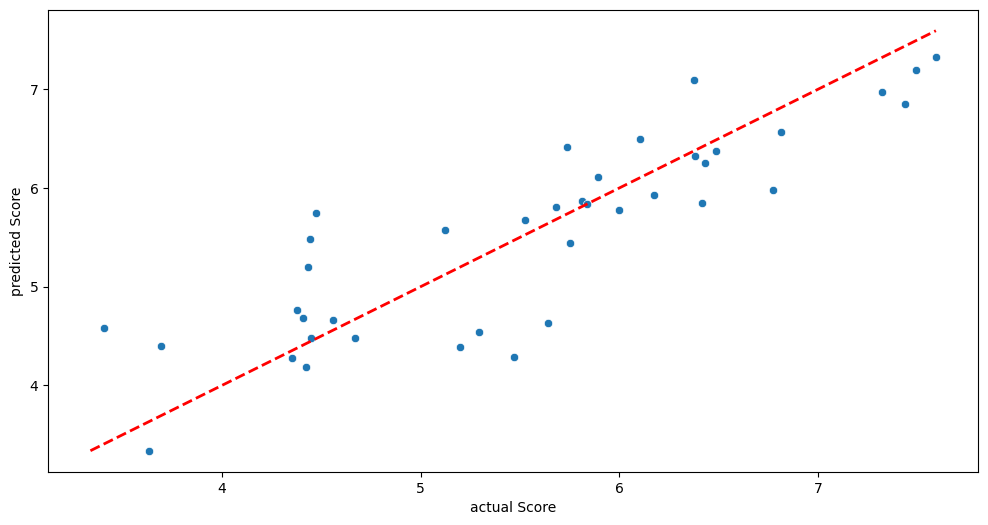

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  117
Model:                            GLM   Df Residuals:                      115
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -210.99
Date:                Sun, 15 Dec 2024   Deviance:                       10.239
Time:                        17:43:53   Pearson chi2:                     10.2
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1399
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.2561      0.112     11.

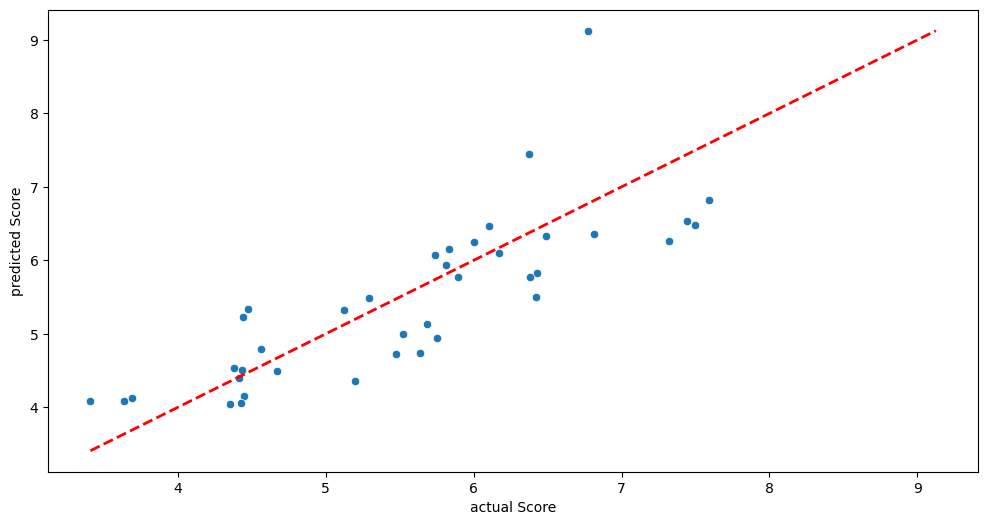

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Score   No. Observations:                  117
Model:                            GLM   Df Residuals:                      114
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -209.35
Date:                Sun, 15 Dec 2024   Deviance:                       6.9655
Time:                        17:43:53   Pearson chi2:                     6.79
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1636
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

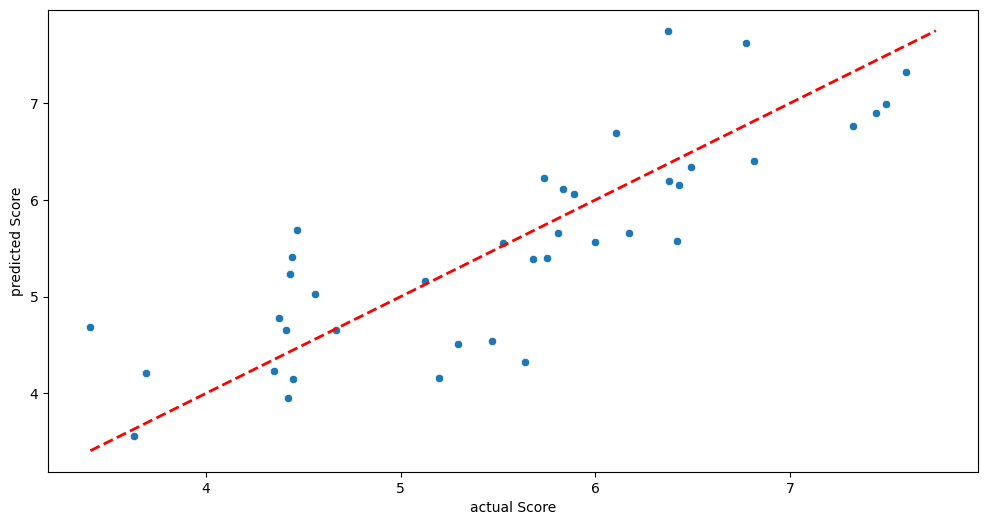

In [66]:
models = ['Score ~ GDP_per_capita + Social_support + Freedom_of_life_choices',
          'Score ~ GDP_per_capita',
          'Score ~ GDP_per_capita + Freedom_of_life_choices']

# initiating table_2
for model in models:

    # getting all the training data together
    train = pd.concat([x_train, y_train], axis=1)
    test = pd.concat([x_test, y_test], axis=1)

    # train full model
    formula = model
    model = smf.glm(formula, train, family = sm.families.Poisson())
    result = model.fit()
    print(result.summary())
    print("The result of the AIC is: ")
    print(round(result.aic,2))

    # calculate explained deviance
    residual_deviance = result.deviance
    null_deviance = result.null_deviance
    deviance_explained = 1 - (residual_deviance / null_deviance)
    print(f"Explained Deviance (Training Data): {deviance_explained:.4f}")

    # predict on test data
    y_predict = result.predict(x_test)
    test_predict = pd.concat([y_test, y_predict], axis=1)
    test_predict = test_predict.reset_index(drop=True)
    test_predict = test_predict.rename(columns={"Score": "actual Score", 0: "predicted Score"})
    test_predict

    # plot actual vs predicted
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=test_predict, x="actual Score", y="predicted Score")
    # Add a diagonal line where actual = predicted
    max_val = max(test_predict["actual Score"].max(), test_predict["predicted Score"].max())
    min_val = min(test_predict["actual Score"].min(), test_predict["predicted Score"].min())
    plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=2, label="Actual = Predicted")
    plt.show()


In [67]:
# first model ('Score ~ GDP_per_capita + Social_support + Freedom_of_life_choices') achives 
# highest explained deviance: 0.7991
# second lowest AIC: 425.34

# --> however, now insignificant p-values of GDP_per_capita, Social_support and Freedom_of_life_choices need to be considered

# a more simpler model (Score ~ GDP_per_capita + Freedom_of_life_choices') achives
# second highest explained deviance: 0.7501
# lowest AIC: 424.71

In [68]:
# note that your values might differ due to random split